In [14]:
from extract_data import get_data_from_directory
from preprocessing import preprocess
from takagi_sugeno_fnn import TS_FNN

import pandas as pd
import random

In [15]:
data = list(get_data_from_directory('./decoded'))
data = preprocess(data)

In [16]:
# pathology_diagnoses = ['H25', 'H26', 'H40']
pathology_diagnoses = ['H25', 'H26']


for d in data:
    d['pathology'] = 1 \
        if any(d['main_diag'].startswith(p_d) for p_d in pathology_diagnoses) or \
           any(any(diag.startswith(p_d) for p_d in pathology_diagnoses) for diag in d['diag']) else 0
len(data)

4037

In [17]:
random.shuffle(data)
test_split = 0.1
split_index = int(test_split * len(data))
test_data, train_data = data[:split_index], data[split_index:]

In [18]:
dataframe = pd.DataFrame(data)
dataframe[:20]

,sex,main_diag,diag,diabetes,age,right_native,correction_right_sphere,correction_right_cylinder,corrected_right,left_native,correction_left_sphere,correction_left_cylinder,corrected_left,pathology
0,m,H35.0,[H25.0],False,72,0.80,0.00,0.0,0.8,0.90,0.00,0.00,0.9,1
1,f,H52.4,[],True,54,0.30,1.00,0.0,1.0,0.90,0.25,0.00,1.0,0
2,f,H52.1,[],True,38,0.10,-1.50,0.0,1.0,0.10,-1.50,0.00,1.0,0
3,m,T15.0,[H10.5],False,60,1.00,0.00,0.0,1.0,0.90,0.00,0.00,0.9,0
4,m,H00.0,[Z03.9],False,44,1.00,0.00,0.0,1.0,1.00,0.00,0.00,1.0,0
5,m,B00.5,[H52.2],False,66,0.70,0.00,-0.5,1.0,0.80,0.25,-0.75,1.0,0
6,f,H10.4,"[H25.0, I10]",False,74,1.00,0.00,0.0,1.0,1.00,0.00,0.00,1.0,1
7,m,H36.0,"[H52.4, H52.0]",True,70,0.20,1.00,0.5,1.0,0.20,0.00,0.00,0.2,0
8,f,H35.9,[H52.0],False,48,0.90,0.75,0.0,1.0,0.40,1.00,0.00,0.9,0
9,f,H52.4,[],False,51,0.90,-0.25,0.0,1.0,0.90,-0.25,0.00,1.0,0


In [19]:
import numpy as np

def abs_max(a, b):
    if abs(a) > abs(b):
        return a
    else:
        return b

def vectorize(data):
    result = []
    for d in data:
        age = int(d['age'])

        result.append([age, min(d['corrected_right'], d['corrected_left']), d['pathology']])
    return np.array(result)

def normalize(data):
    return [[d[0]/100, d[1], d[2]] for d in data]

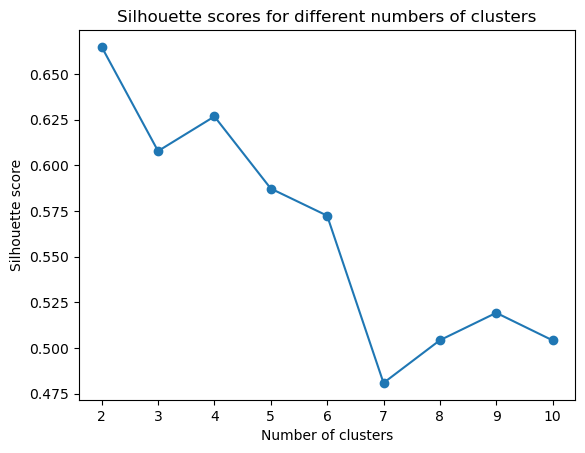

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette_scores = []
X = normalize(vectorize(data))

for n_clusters in range_n_clusters:
    # Create KMeans instance
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
    cluster_labels = kmeans.fit_predict(X)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plotting the silhouette scores
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette scores for different numbers of clusters')
plt.xticks(range_n_clusters)
plt.show()

In [21]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto')
kmeans.fit(X)
kmeans.cluster_centers_

array([[4.88674783e-01, 8.54542609e-01, 5.55111512e-16],
       [7.24569707e-01, 4.18115318e-01, 1.00000000e+00]])

# Training FNN

In [28]:
vectorized_train_data = normalize(vectorize(train_data))
X = np.array([data[0:-1] for data in vectorized_train_data])
Y = np.array([data[-1] for data in vectorized_train_data])

ts_fnn = TS_FNN([2, 2], [[1, 0], [1, 1], [0, 1]])
ts_fnn.parameters = ([[0.30, 0.60], [0., 1.]],
                     ts_fnn.parameters[1],
                     ts_fnn.parameters[2],
                     ts_fnn.parameters[3])
ts_fnn.fit(X, Y, epochs=20, learning_rate=0.0001, gradient_accumulation_step=64)

Iteration 1 Epoch 0 log likelihood -13200.996620173479
Iteration 2 Epoch 0 log likelihood -12818.3879738221
Iteration 3 Epoch 0 log likelihood -11463.330685572757
Iteration 4 Epoch 0 log likelihood -11658.932313190637
Iteration 5 Epoch 0 log likelihood -9806.034235456267
Iteration 6 Epoch 0 log likelihood -9056.715684321414
Iteration 7 Epoch 0 log likelihood -8965.32503836511
Iteration 8 Epoch 0 log likelihood -8041.938319194173
Iteration 9 Epoch 0 log likelihood -7828.002756075874
Iteration 10 Epoch 0 log likelihood -7651.983107263291
Iteration 11 Epoch 0 log likelihood -6902.646976658688
Iteration 12 Epoch 0 log likelihood -6580.293817019113
Iteration 13 Epoch 0 log likelihood -5966.736151715316
Iteration 14 Epoch 0 log likelihood -4415.304438384958
Iteration 15 Epoch 0 log likelihood -4468.527241534452
Iteration 16 Epoch 0 log likelihood -4428.362410195057
Iteration 17 Epoch 0 log likelihood -3911.6276520577926
Iteration 18 Epoch 0 log likelihood -3897.2952689841372
Iteration 19 Epo

In [23]:
ts_fnn.parameters

([[array(0.30832085), array(0.59480471)],
  [array(-0.17912841), array(1.13487105)]],
 [array([0.99981198, 0.99937442]), array([0.63691996, 0.86220269])],
 array([ 0.5622125 , -0.11727105, -0.10373967]),
 [array([0.90781498, 0.42842661]),
  array([ 0.55850718, -0.19566778]),
  array([ 0.56868534, -0.18136596])])

# Testing

In [24]:
from testing import test_prediction, print_test_results, false_positives, false_negatives

In [25]:
vectorized_test_data = normalize(vectorize(test_data))
X = np.array([data[0:-1] for data in vectorized_test_data])
Y = np.array([data[-1] for data in vectorized_test_data])
prediction_fun = lambda x: round(ts_fnn.predict(x))

print_test_results(*test_prediction(prediction_fun, X, Y))

Precision: 0.6989247311827957
Recall: 0.5803571428571429
F1-score: 0.6341463414634146
Confusion Matrix:
                Predicted p Predicted n
Actual p          65.000   47.000
Actual n          28.000  263.000


0.6341463414634146

In [26]:
false_negatives(prediction_fun, X, Y)

[array([0.72, 0.8 ]),
 array([0.74, 1.  ]),
 array([0.74, 0.9 ]),
 array([0.81, 0.7 ]),
 array([0.75, 0.6 ]),
 array([0.63, 0.8 ]),
 array([0.68, 0.9 ]),
 array([0.68, 1.  ]),
 array([0.65, 0.9 ]),
 array([0.46, 0.9 ]),
 array([0.83, 0.9 ]),
 array([0.83, 0.9 ]),
 array([0.65, 0.9 ]),
 array([0.79, 0.8 ]),
 array([0.63, 1.  ]),
 array([0.74, 0.6 ]),
 array([0.67, 0.8 ]),
 array([0.59, 1.  ]),
 array([0.7, 0.6]),
 array([0.75, 1.  ]),
 array([0.72, 1.  ]),
 array([0.7, 0.9]),
 array([0.71, 0.9 ]),
 array([0.75, 0.7 ]),
 array([0.73, 1.  ]),
 array([0.78, 0.7 ]),
 array([0.65, 0.9 ]),
 array([0.72, 0.6 ]),
 array([0.63, 0.5 ]),
 array([0.66, 1.  ]),
 array([0.71, 1.  ]),
 array([0.67, 0.9 ]),
 array([0.68, 0.9 ]),
 array([0.66, 0.5 ]),
 array([0.62, 1.  ]),
 array([0.68, 0.9 ]),
 array([0.8, 0.9]),
 array([0.67, 1.  ]),
 array([0.61, 1.  ]),
 array([0.79, 0.7 ]),
 array([0.71, 1.  ]),
 array([0.69, 1.  ]),
 array([0.78, 0.9 ]),
 array([0.68, 0.9 ]),
 array([0.69, 1.  ]),
 array([0.66, 1.